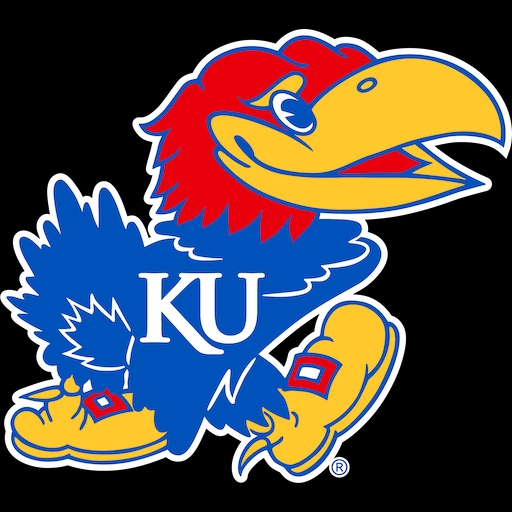

In [61]:
from pathlib import Path
from PIL import Image
import numpy as np
from sympy import Matrix

filename = Path("../img/color/Jayhawk_512x512.jpg")

with Image.open(filename, "r") as im:
    display(im)

# True for noisy execution, False for noiseless execution
noisy_execution = False
draw_qc = True

In [62]:
def display_quantum_circuit(qc):
    if draw_qc:
        display(qc.draw('mpl', reverse_bits=True))

In [63]:
%run ../src/filters.py

stride = 1
num_layers = 8
fltr_raw = avg_filter(2, dim = 2)
# fltr_raw = sobel_filter(3, axis=0)
# fltr_raw = laplacian()
# fltr_raw = gaussian_blur()

npad = tuple((0, 2 ** int(np.ceil(np.log2(N))) - N) for N in fltr_raw.shape)
fltr = np.pad(fltr_raw, pad_width=npad, mode="constant", constant_values=0)

Matrix(fltr)

Matrix([
[0.25, 0.25],
[0.25, 0.25]])

In [64]:
%run ../src/kuarq.py

psi, *dims = flatten_image(filename, pad=True)
psi, mag = normalize(psi, include_magnitude=True)

n_dim = len(dims)

num_qubits = 0
wires = []
for dim in dims:
    root, num_qubits = num_qubits, num_qubits + to_qubits(dim)
    wires.append(list(range(root, num_qubits)))

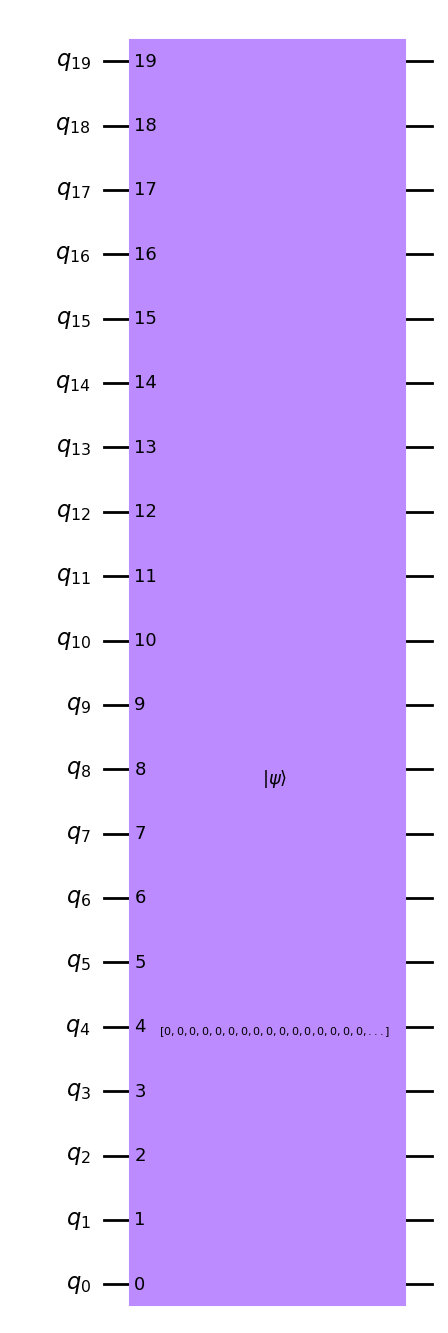

In [65]:
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

qc = QuantumCircuit(num_qubits)
qc.initialize(psi)

display_quantum_circuit(qc)

In [66]:
def conv_pool_hybrid(
    qc: QuantumCircuit, wires, fltr, stride: int = 1, n_dim: int = None
):
    if n_dim is None:
        n_dim = len(wires)

    if len(wires) < n_dim + fltr.ndim:
        wires.extend([[] for _ in range(fltr.ndim + n_dim - len(wires))])
    fltr_shape_q = [to_qubits(filter_size) for filter_size in fltr.shape]

    params, fltr_mag = normalize(fltr.flatten(order="F"), include_magnitude=True)

    ### Shift operation
    controls = [[] for _ in range(fltr.ndim)]
    for i, fq in enumerate(fltr_shape_q):
        ctrl_qubits, img_qubits = wires[i][:fq], wires[i][fq:]
        wires[i] = img_qubits
        controls[i] = ctrl_qubits

        for j, control_qubit in enumerate(ctrl_qubits):
            shift(qc, -stride, targets=img_qubits[j:], control=control_qubit)

    ### Filter using C2Q
    filter_qubits = np.array([wires_d[:fq] for wires_d, fq in zip(wires, fltr_shape_q)])
    c2q(qc, params, targets=filter_qubits.flatten(), transpose=True)

    for j, (ctrls, trgts) in enumerate(zip(controls, wires)):
        wires[n_dim + j].extend(ctrls)
        for c, t in zip(ctrls, trgts):
            qc.swap(c, t)

    return wires, fltr_mag

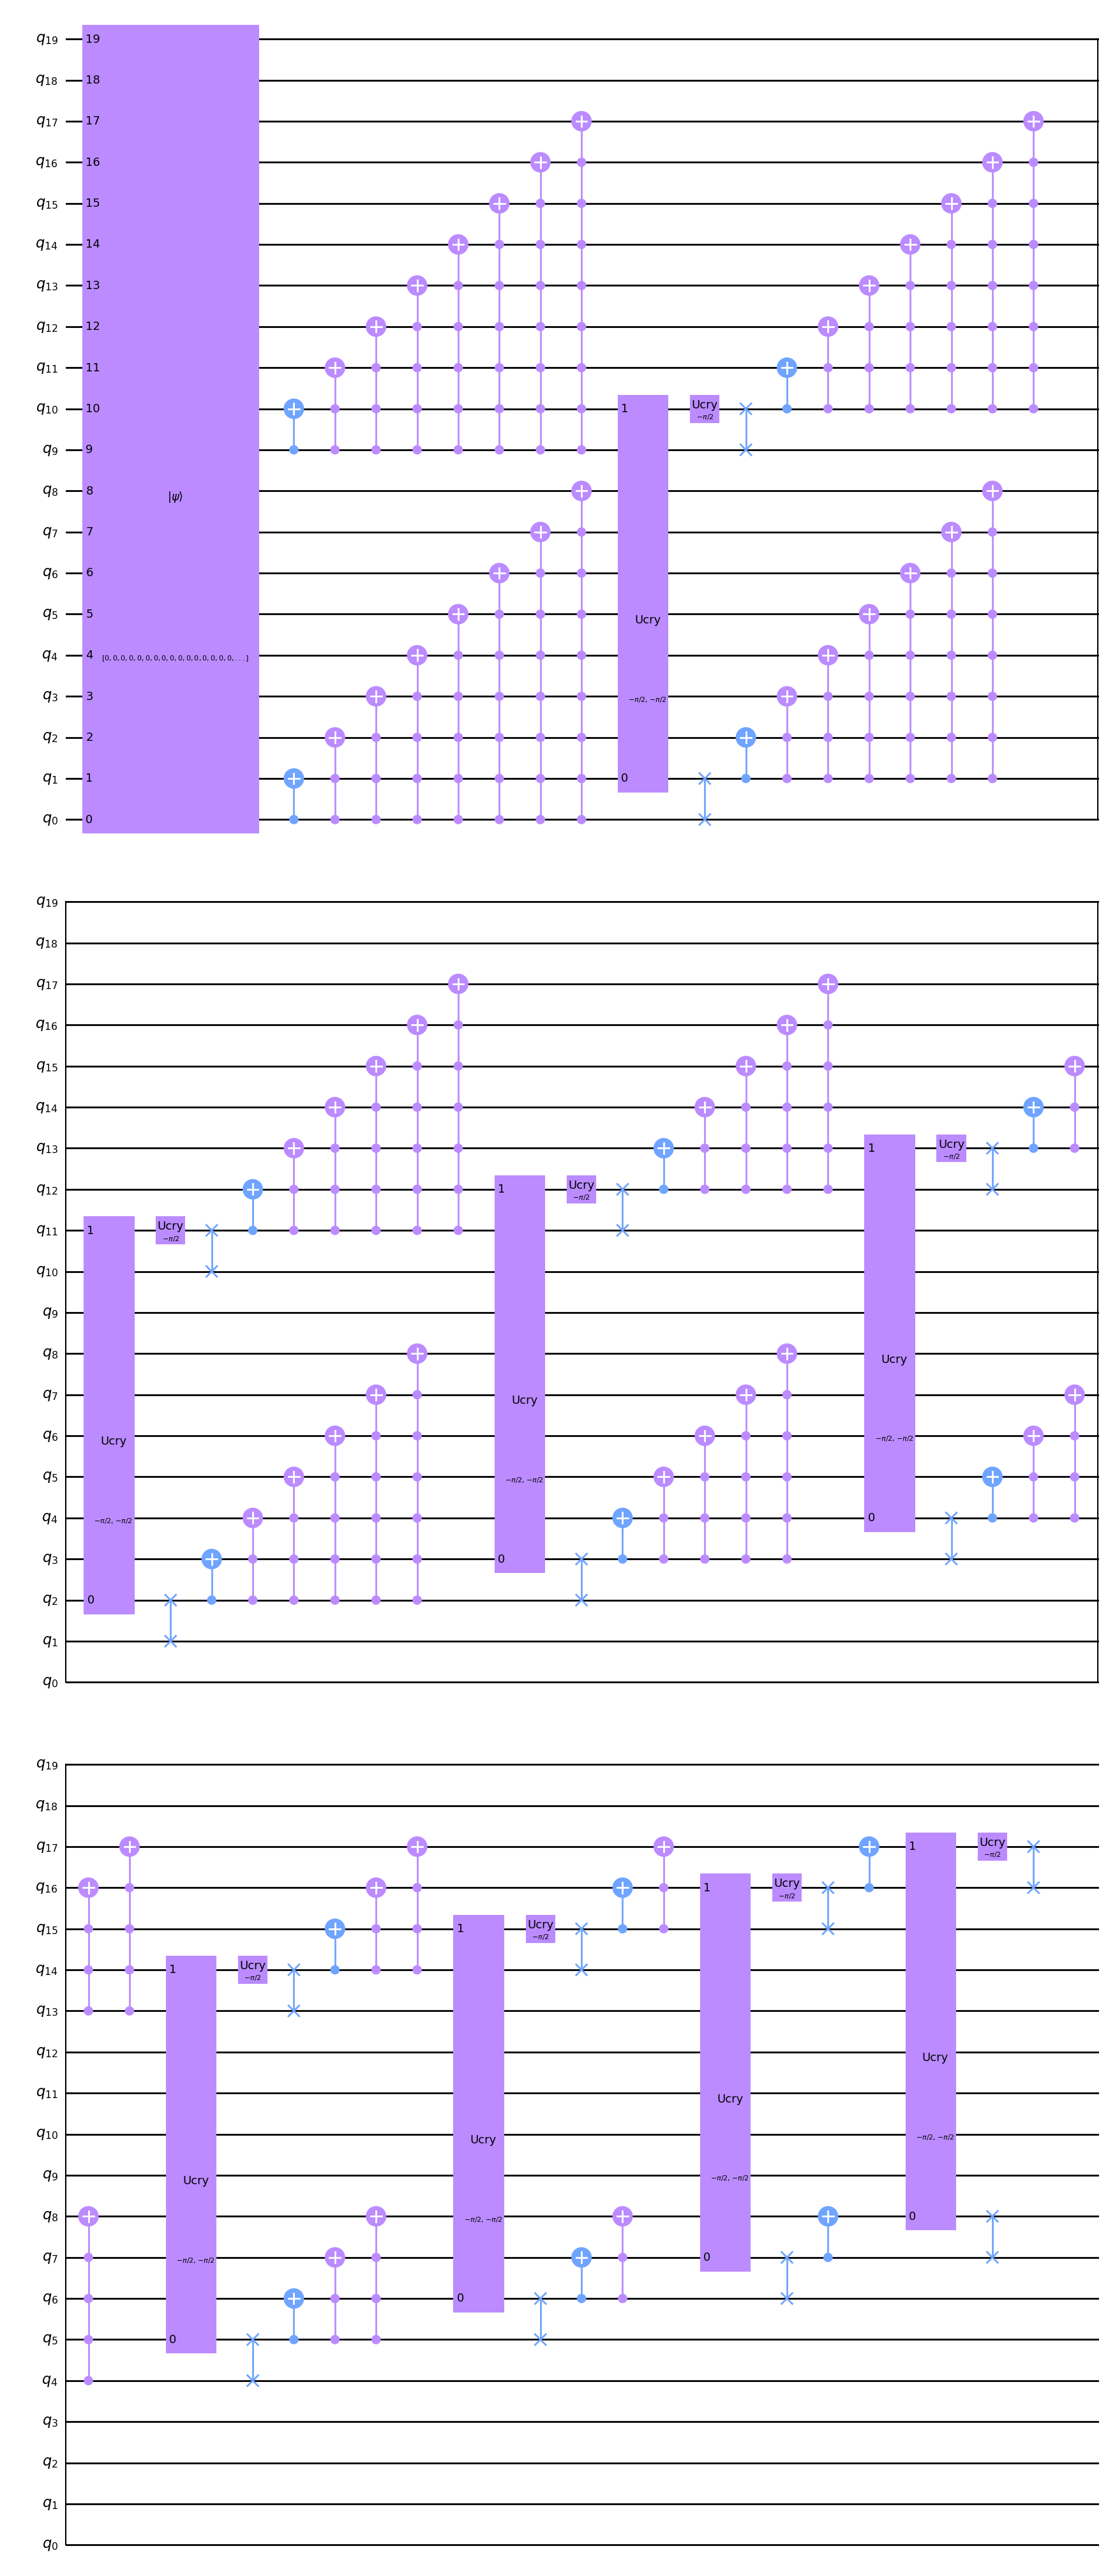

In [67]:
wires_old = wires.copy()
fltr_mag = 1
for _ in range(num_layers):
    wires, fm = conv_pool_hybrid(qc, wires, fltr, stride, n_dim)
    fltr_mag *= fm

display_quantum_circuit(qc)

[[8], [17], [18, 19], [0, 1, 2, 3, 4, 5, 6, 7], [9, 10, 11, 12, 13, 14, 15, 16]]


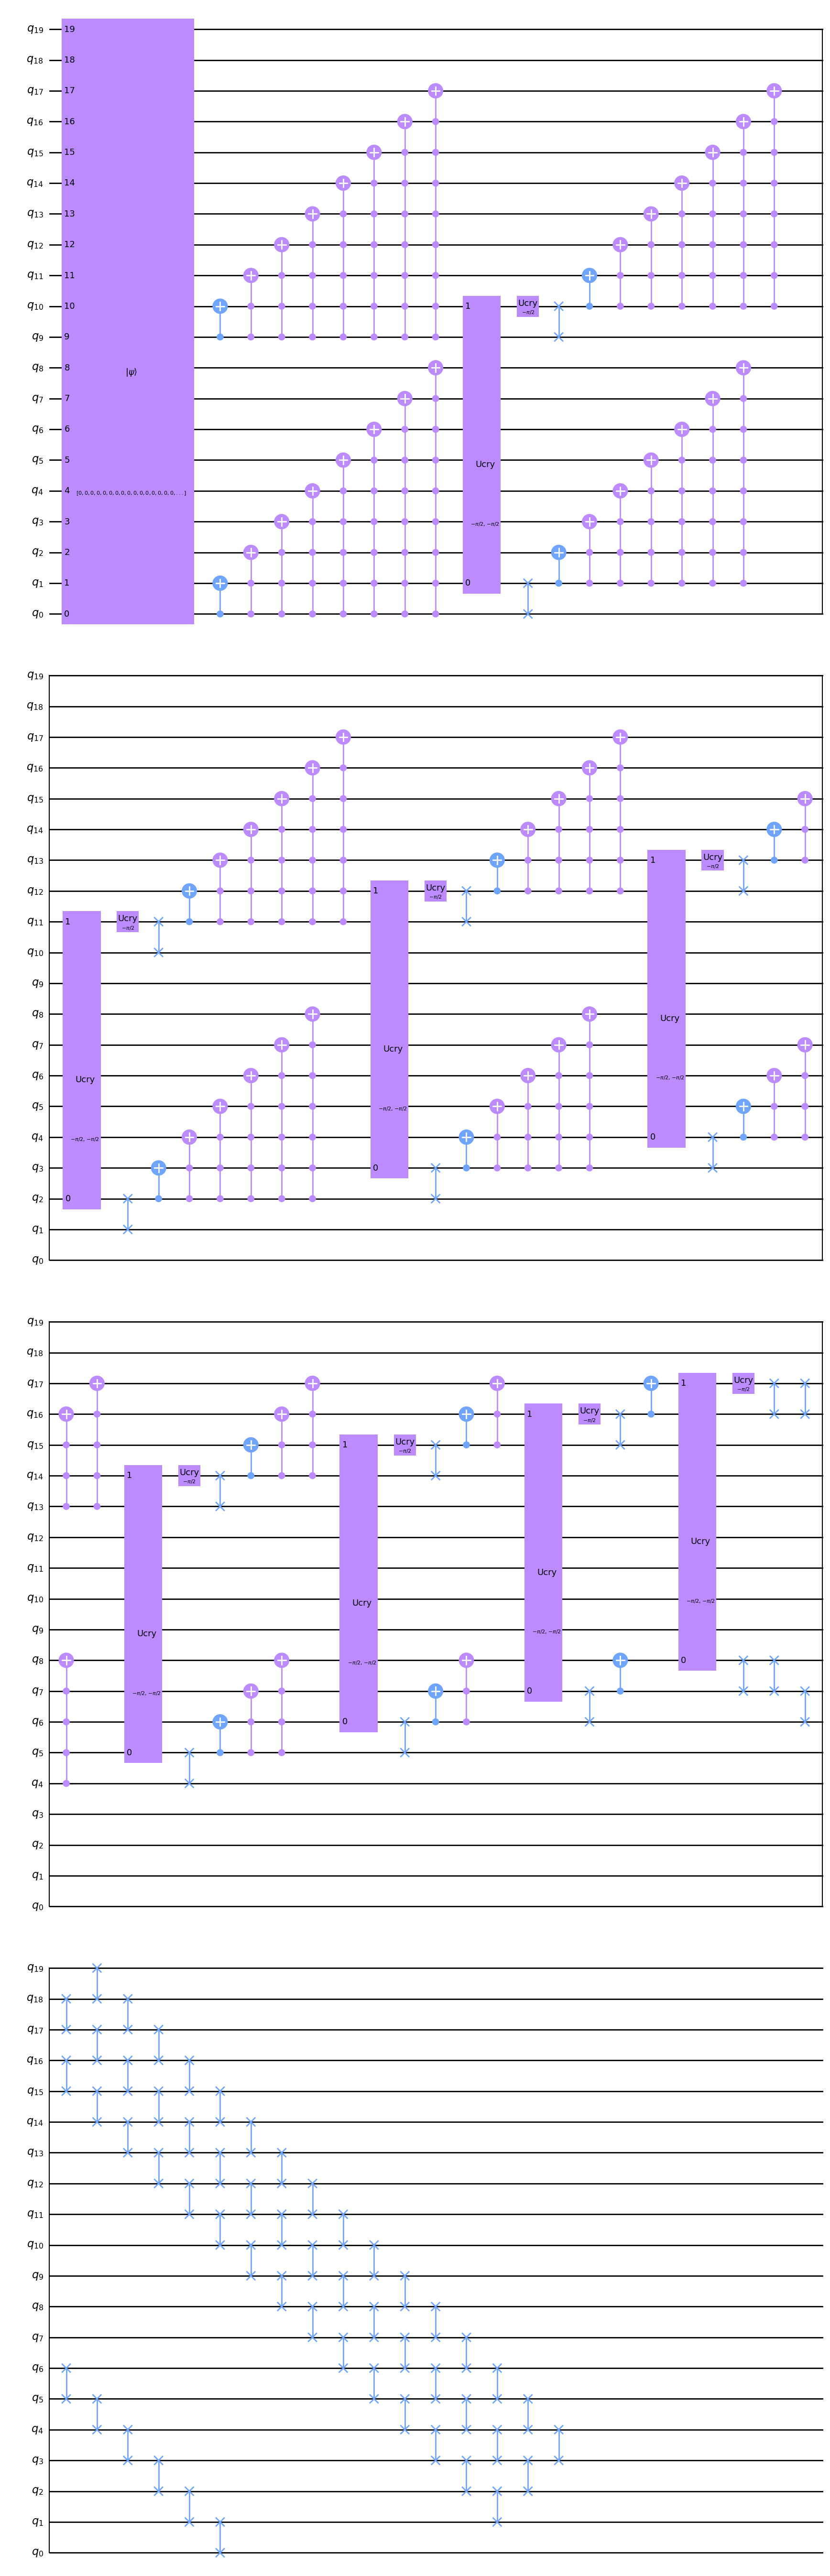

In [68]:
print(wires)

### Permutations for qiskit only
fltr_shape_q = [to_qubits(filter_size) for filter_size in fltr.shape]
for i, fq in reversed(list(enumerate(fltr_shape_q))):
    offset = sum([len(w) for w in wires[:n_dim + i]])
    for j, w in reversed(list(enumerate(wires[n_dim + i]))):
        rotate(qc, w, offset+j)
        
display_quantum_circuit(qc)

In [69]:
from qiskit import Aer, execute
from qiskit.tools import job_monitor

backend = Aer.get_backend('aer_simulator')
shots = backend.configuration().max_shots

if noisy_execution:
    qc.measure_all()
else:
    qc.save_statevector()

job = execute(qc, backend=backend, shots=shots)
job_monitor(job)

result = job.result()

if noisy_execution:
    counts = result.get_counts(qc)
    psi_out = from_counts(counts, shots=shots, num_qubits=num_qubits)
else:
    psi_out = result.get_statevector(qc).data

Job Status: job has successfully run


In [70]:
scaling = [2**(len(wo) - len(w)) for w, wo in zip(wires, wires_old)]
dims = [d // s for d, s in zip(dims, scaling)]
num_states = np.prod([2**to_qubits(dim) for dim in dims])

In [71]:
i = 0
img = psi_out.data[i*num_states:(i+1)*num_states]
norm = mag * fltr_mag # * np.sqrt(2**num_ancilla)
img = construct_img(norm*img, dims)
img.save("output.png")

display(img)